In [1]:
# Install library (jalankan sekali saja kalau belum terinstall)
!pip install seaborn
!pip install textblob

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import textblob
import re
import time
import datetime
import os

from pathlib import Path
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from PIL import Image

# Matplotlib & Seaborn settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (15,10)



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ------ --------------------------------- 0.3/1.5 MB ? eta -:--:--
   ------ --------------------------------- 0.3/1.5 MB ? eta -:--:--
   ------ --------------------------------- 0.3/1.5 MB ? eta -:--:--
   ------ --------------------------------- 0.3/1.5 MB ? eta -:--:--
   ------ --------------------------------- 0.3/1.5 MB ? eta -:--:--
   ------ --------------------------------- 0.3/1.5 MB ? eta -:--:--
   ------ --------------------------------- 0.3/1.5 MB ? eta -:--:--
   ------------- -------------------------- 0.5/1.5 MB 185.8 kB/s eta 0:00:06
   ------------- -------------------------- 0.5/1.5 MB 185.8 kB/s eta 0:00:06
   -------------------- ------------------- 0.8/1.5 MB 286.2 kB/s eta 0:00:03
   --------------------------- ------------ 1.0/1.5 MB 357.0 kB/s eta 0:00:02
   --------------------------- ------------ 1.0/1.5 MB 357.0 kB/s e


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import pandas as pd

# Baca file hasil preprocessing Gojek
gojek_news_df = pd.read_csv('./Data/gojek_news_preprocessed.csv')

# Tampilkan 5 baris pertama untuk cek data
print(gojek_news_df.head())

# (Opsional) Simpan ulang sebagai versi raw, kalau mau dipakai ulang
gojek_news_df.to_csv('./Data/gojek_news_raw.csv', index=False)


                                               judul  \
0  Tarif Ojol Naik 15 Persen, Pakar Transportasi ...   
1  Gojek Siap Kaji Perubahan Tarif Ojek Online Me...   
2  Kenaikan Tarif Ojol Sarat Risiko, Pemerintah P...   
3  Gojek Pastikan Ikuti Kebijakan Kenaikan Tarif ...   
4  Mengatur (Potongan) Aplikasi Ojek Online. – FA...   

                              authors                 source  \
0                    Rahajeng Kartika        beritajatim.com   
1          Harian Jogja Digital Media  ekbis.harianjogja.com   
2  Rio Sandy Pradana, Penulis, Editor     ekonomi.bisnis.com   
3           Asfian Nur Muhammad, Oleh    ekonomi.rakyat.news   
4                                 NaN            fakta.or.id   

              published_date  summary  \
0  2025-07-24 22:49:04+00:00      NaN   
1                        NaN      NaN   
2  2025-07-01 08:07:28+00:00      NaN   
3  2025-07-02 02:06:15+00:00      NaN   
4                        NaN      NaN   

                               

In [6]:
# Ubah semua teks di kolom 'content' jadi lowercase

# Pastikan kolomnya bertipe string
gojek_news_df['content'] = gojek_news_df['content'].astype(str)

# Cek jumlah data
print(f"Jumlah data: {len(gojek_news_df)}\n")

# Tampilkan beberapa contoh sebelum lowercase
print("Sebelum lowercase:")
print(gojek_news_df['content'].head(3))  # hanya tampilkan 3 baris pertama

# Terapkan lowercase
gojek_news_df['content'] = gojek_news_df['content'].str.lower()

# Tampilkan hasil sesudah lowercase
print("\nSetelah lowercase:")
print(gojek_news_df['content'].head(3))


Jumlah data: 97

Sebelum lowercase:
0    Yogyakarta (beritajatim.com)– Pemerintah melal...
1    Gojek Siap Kaji Perubahan Tarif Ojek Online Me...
2    RISED menilai penerapan kenaikan tarif ojol di...
Name: content, dtype: object

Setelah lowercase:
0    yogyakarta (beritajatim.com)– pemerintah melal...
1    gojek siap kaji perubahan tarif ojek online me...
2    rised menilai penerapan kenaikan tarif ojol di...
Name: content, dtype: object


In [7]:
import nltk
from nltk.tokenize import word_tokenize

# pastikan resource punkt sudah ada
nltk.download('punkt')

# bikin kolom baru 'tokens' hasil tokenisasi
gojek_news_df['tokens'] = gojek_news_df['content'].apply(word_tokenize)

# cek hasilnya
print(gojek_news_df[['content', 'tokens']].head(10))


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fajri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


                                             content  \
0  yogyakarta (beritajatim.com)– pemerintah melal...   
1  gojek siap kaji perubahan tarif ojek online me...   
2  rised menilai penerapan kenaikan tarif ojol di...   
3  rakyat news, jakarta – induk perusahaan gojek,...   
4  hari ini, 20 mei 2025 ojek online melakukan ak...   
5  masalah ojek online belum juga tuntas hingga s...   
6  kementerian perhubungan (kemenhub) menyesuaika...   
7  per 14 agustus besok, tarif baru ojek online (...   
8  research institute for socio-economic developm...   
9  perusahaan teknologi asal indonesia, gojek, be...   

                                              tokens  
0  [yogyakarta, (, beritajatim.com, ), –, pemerin...  
1  [gojek, siap, kaji, perubahan, tarif, ojek, on...  
2  [rised, menilai, penerapan, kenaikan, tarif, o...  
3  [rakyat, news, ,, jakarta, –, induk, perusahaa...  
4  [hari, ini, ,, 20, mei, 2025, ojek, online, me...  
5  [masalah, ojek, online, belum, juga, tuntas, h... 

In [8]:

import nltk
import matplotlib.pyplot as plt
import pandas as pd
from nltk.corpus import stopwords
from collections import Counter

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fajri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:

# Get Indonesian stopwords
indonesian_stopwords = stopwords.words('indonesian')

# Display first 20 stopwords
print(indonesian_stopwords[:20])

['ada', 'adalah', 'adanya', 'adapun', 'agak', 'agaknya', 'agar', 'akan', 'akankah', 'akhir', 'akhiri', 'akhirnya', 'aku', 'akulah', 'amat', 'amatlah', 'anda', 'andalah', 'antar', 'antara']


,Word,Frequency
0,tarif,404
1,gojek,399
2,ojek,340
3,online,280
4,pengemudi,266
...,...,...
95,with,35
96,content,35
97,jam,35
98,order,34


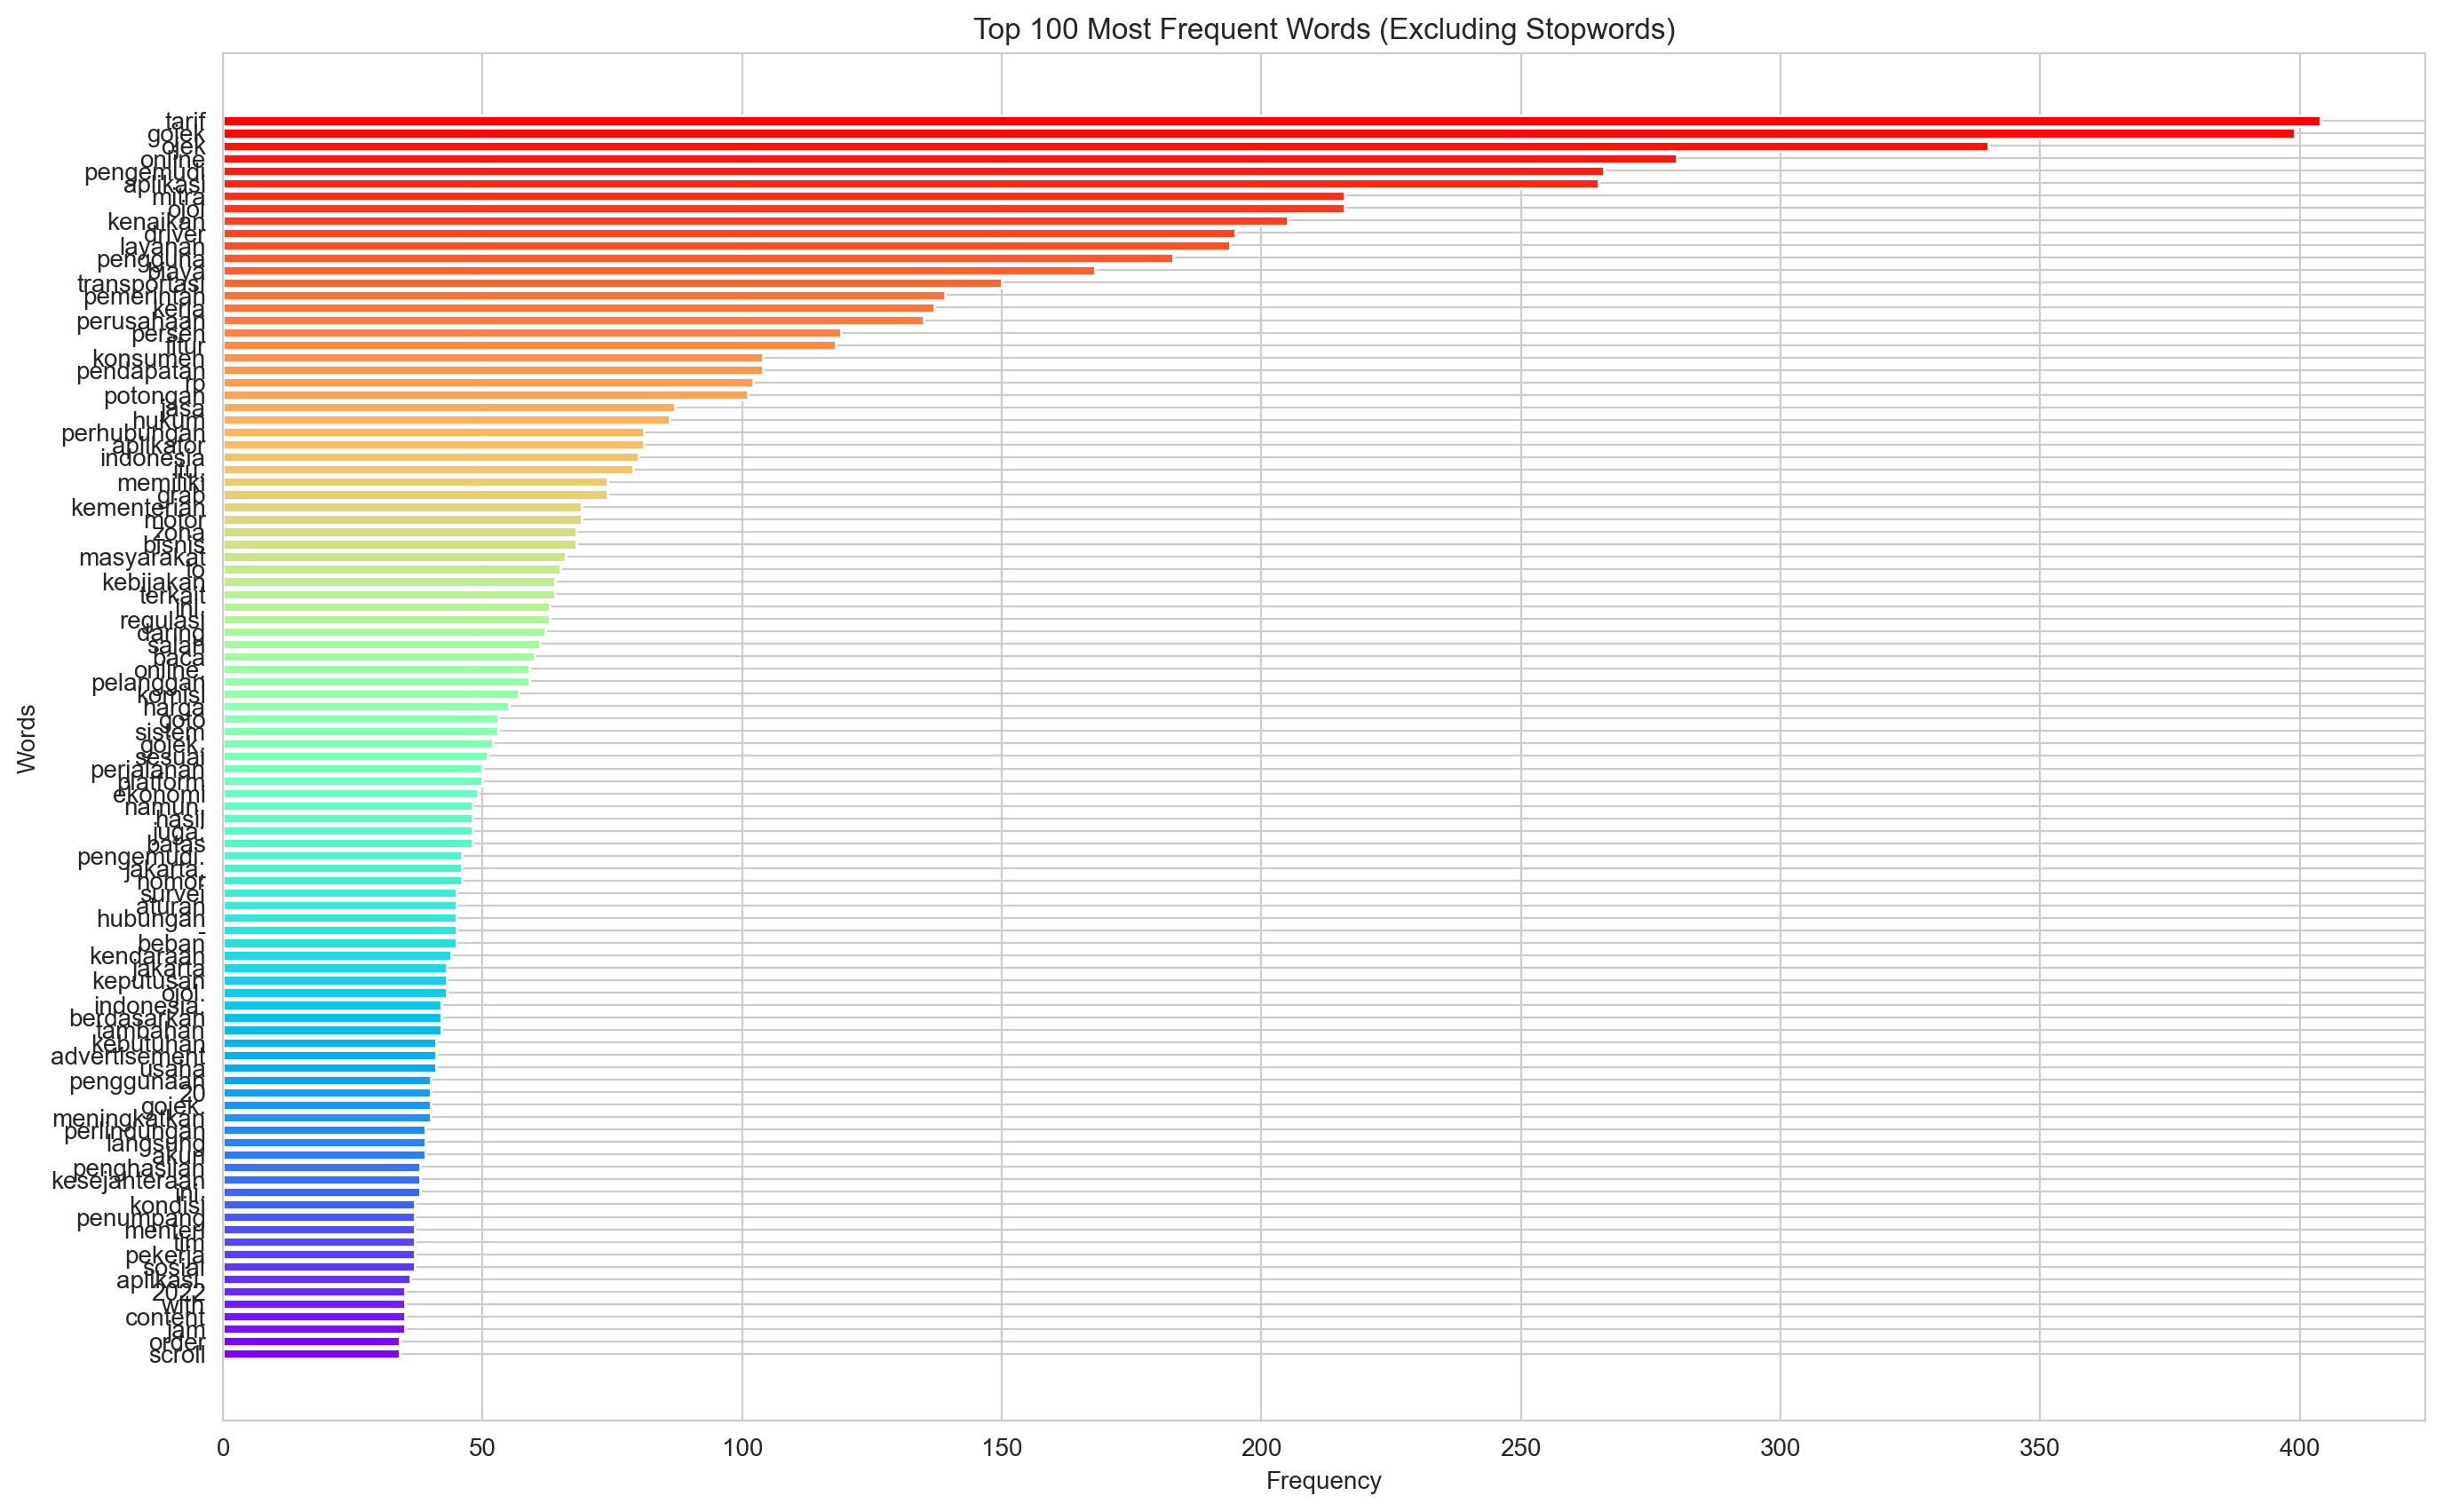

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter

# Assuming the text column is named 'content'
text_column = 'content'

# Combine all text data into one string
all_text = ' '.join(gojek_news_df[text_column].dropna().astype(str))

# Tokenize words and remove stopwords
words = all_text.split()
filtered_words = [word.lower() for word in words if word.lower() not in indonesian_stopwords]

# Count frequent words
word_counts = Counter(filtered_words)
common_words = word_counts.most_common(100)

# Convert to DataFrame for better visualization
word_freq_df = pd.DataFrame(common_words, columns=['Word', 'Frequency'])

# Display the most common words
display(word_freq_df)

# Plot the frequent words with rainbow colormap (horizontal barplot)
plt.figure(figsize=(16, 10))

# generate warna rainbow sesuai jumlah kata
colors = plt.cm.rainbow(np.linspace(0, 1, len(word_freq_df)))

# plot horizontal bar
bars = plt.barh(
    word_freq_df['Word'][::-1],
    word_freq_df['Frequency'][::-1],
    color=colors
)

plt.xlabel("Frequency")
plt.ylabel("Words")
plt.title("Top 100 Most Frequent Words (Excluding Stopwords)")
plt.show()

In [12]:
common_words


[('tarif', 404),
 ('gojek', 399),
 ('ojek', 340),
 ('online', 280),
 ('pengemudi', 266),
 ('aplikasi', 265),
 ('mitra', 216),
 ('ojol', 216),
 ('kenaikan', 205),
 ('driver', 195),
 ('layanan', 194),
 ('pengguna', 183),
 ('biaya', 168),
 ('transportasi', 150),
 ('pemerintah', 139),
 ('kerja', 137),
 ('perusahaan', 135),
 ('persen', 119),
 ('fitur', 118),
 ('konsumen', 104),
 ('pendapatan', 104),
 ('rp', 102),
 ('potongan', 101),
 ('jasa', 87),
 ('hukum', 86),
 ('perhubungan', 81),
 ('aplikator', 81),
 ('indonesia', 80),
 ('itu,', 79),
 ('memiliki', 74),
 ('grab', 74),
 ('kementerian', 69),
 ('motor', 69),
 ('zona', 68),
 ('bisnis', 68),
 ('masyarakat', 66),
 ('to', 65),
 ('kebijakan', 64),
 ('terkait', 64),
 ('ini,', 63),
 ('regulasi', 63),
 ('daring', 62),
 ('salah', 61),
 ('baca', 60),
 ('online.', 59),
 ('pelanggan', 59),
 ('komisi', 57),
 ('harga', 55),
 ('goto', 53),
 ('sistem', 53),
 ('gojek,', 52),
 ('sesuai', 51),
 ('perjalanan', 50),
 ('platform', 50),
 ('ekonomi', 49),
 ('namu

In [13]:
# Pastikan indonesian_stopwords berbentuk set
indonesian_stopwords = set(indonesian_stopwords)

# Add custom stopwords dari hasil top 100 frequent words
custom_stopwords = {
    # filler umum
    "ga", "gak", "gk", "udah", "udh", "aja", "aja", "aja", "ya", "tp", "bgt", "ok", "gw", "sih",
    # kata ganti/partikel
    "nya", "yg", "kalo", "d", "in",
    # tanda baca/angka
    ",", ".", "1", "2",
    # umum tidak bermakna kontekstual
    "aja", "mulu", "udah", "udh", "sampe"
}


# Pastikan kata-kata penting tidak ikut jadi stopwords
for word in ["aplikasi", "apk", "app"]:
    indonesian_stopwords.discard(word)

# Merge with existing stopwords
indonesian_stopwords.update(custom_stopwords)

print("Updated stopwords:", sorted(indonesian_stopwords))

Updated stopwords: [',', '.', '1', '2', 'ada', 'adalah', 'adanya', 'adapun', 'agak', 'agaknya', 'agar', 'aja', 'akan', 'akankah', 'akhir', 'akhiri', 'akhirnya', 'aku', 'akulah', 'amat', 'amatlah', 'anda', 'andalah', 'antar', 'antara', 'antaranya', 'apa', 'apaan', 'apabila', 'apakah', 'apalagi', 'apatah', 'artinya', 'asal', 'asalkan', 'atas', 'atau', 'ataukah', 'ataupun', 'awal', 'awalnya', 'bagai', 'bagaikan', 'bagaimana', 'bagaimanakah', 'bagaimanapun', 'bagi', 'bagian', 'bahkan', 'bahwa', 'bahwasanya', 'baik', 'bakal', 'bakalan', 'balik', 'banyak', 'bapak', 'baru', 'bawah', 'beberapa', 'begini', 'beginian', 'beginikah', 'beginilah', 'begitu', 'begitukah', 'begitulah', 'begitupun', 'bekerja', 'belakang', 'belakangan', 'belum', 'belumlah', 'benar', 'benarkah', 'benarlah', 'berada', 'berakhir', 'berakhirlah', 'berakhirnya', 'berapa', 'berapakah', 'berapalah', 'berapapun', 'berarti', 'berawal', 'berbagai', 'berdatangan', 'beri', 'berikan', 'berikut', 'berikutnya', 'berjumlah', 'berkali-k

🔎 Words removed by custom stopwords:


,Word,Frequency
0,yang,1262
1,dan,1011
2,di,632
3,untuk,534
4,dengan,472
...,...,...
482,macam,1
483,terjadilah,1
484,dini,1
485,usah,1


,Word,Frequency
0,tarif,404
1,gojek,399
2,ojek,340
3,online,280
4,pengemudi,266
...,...,...
95,with,35
96,content,35
97,jam,35
98,order,34


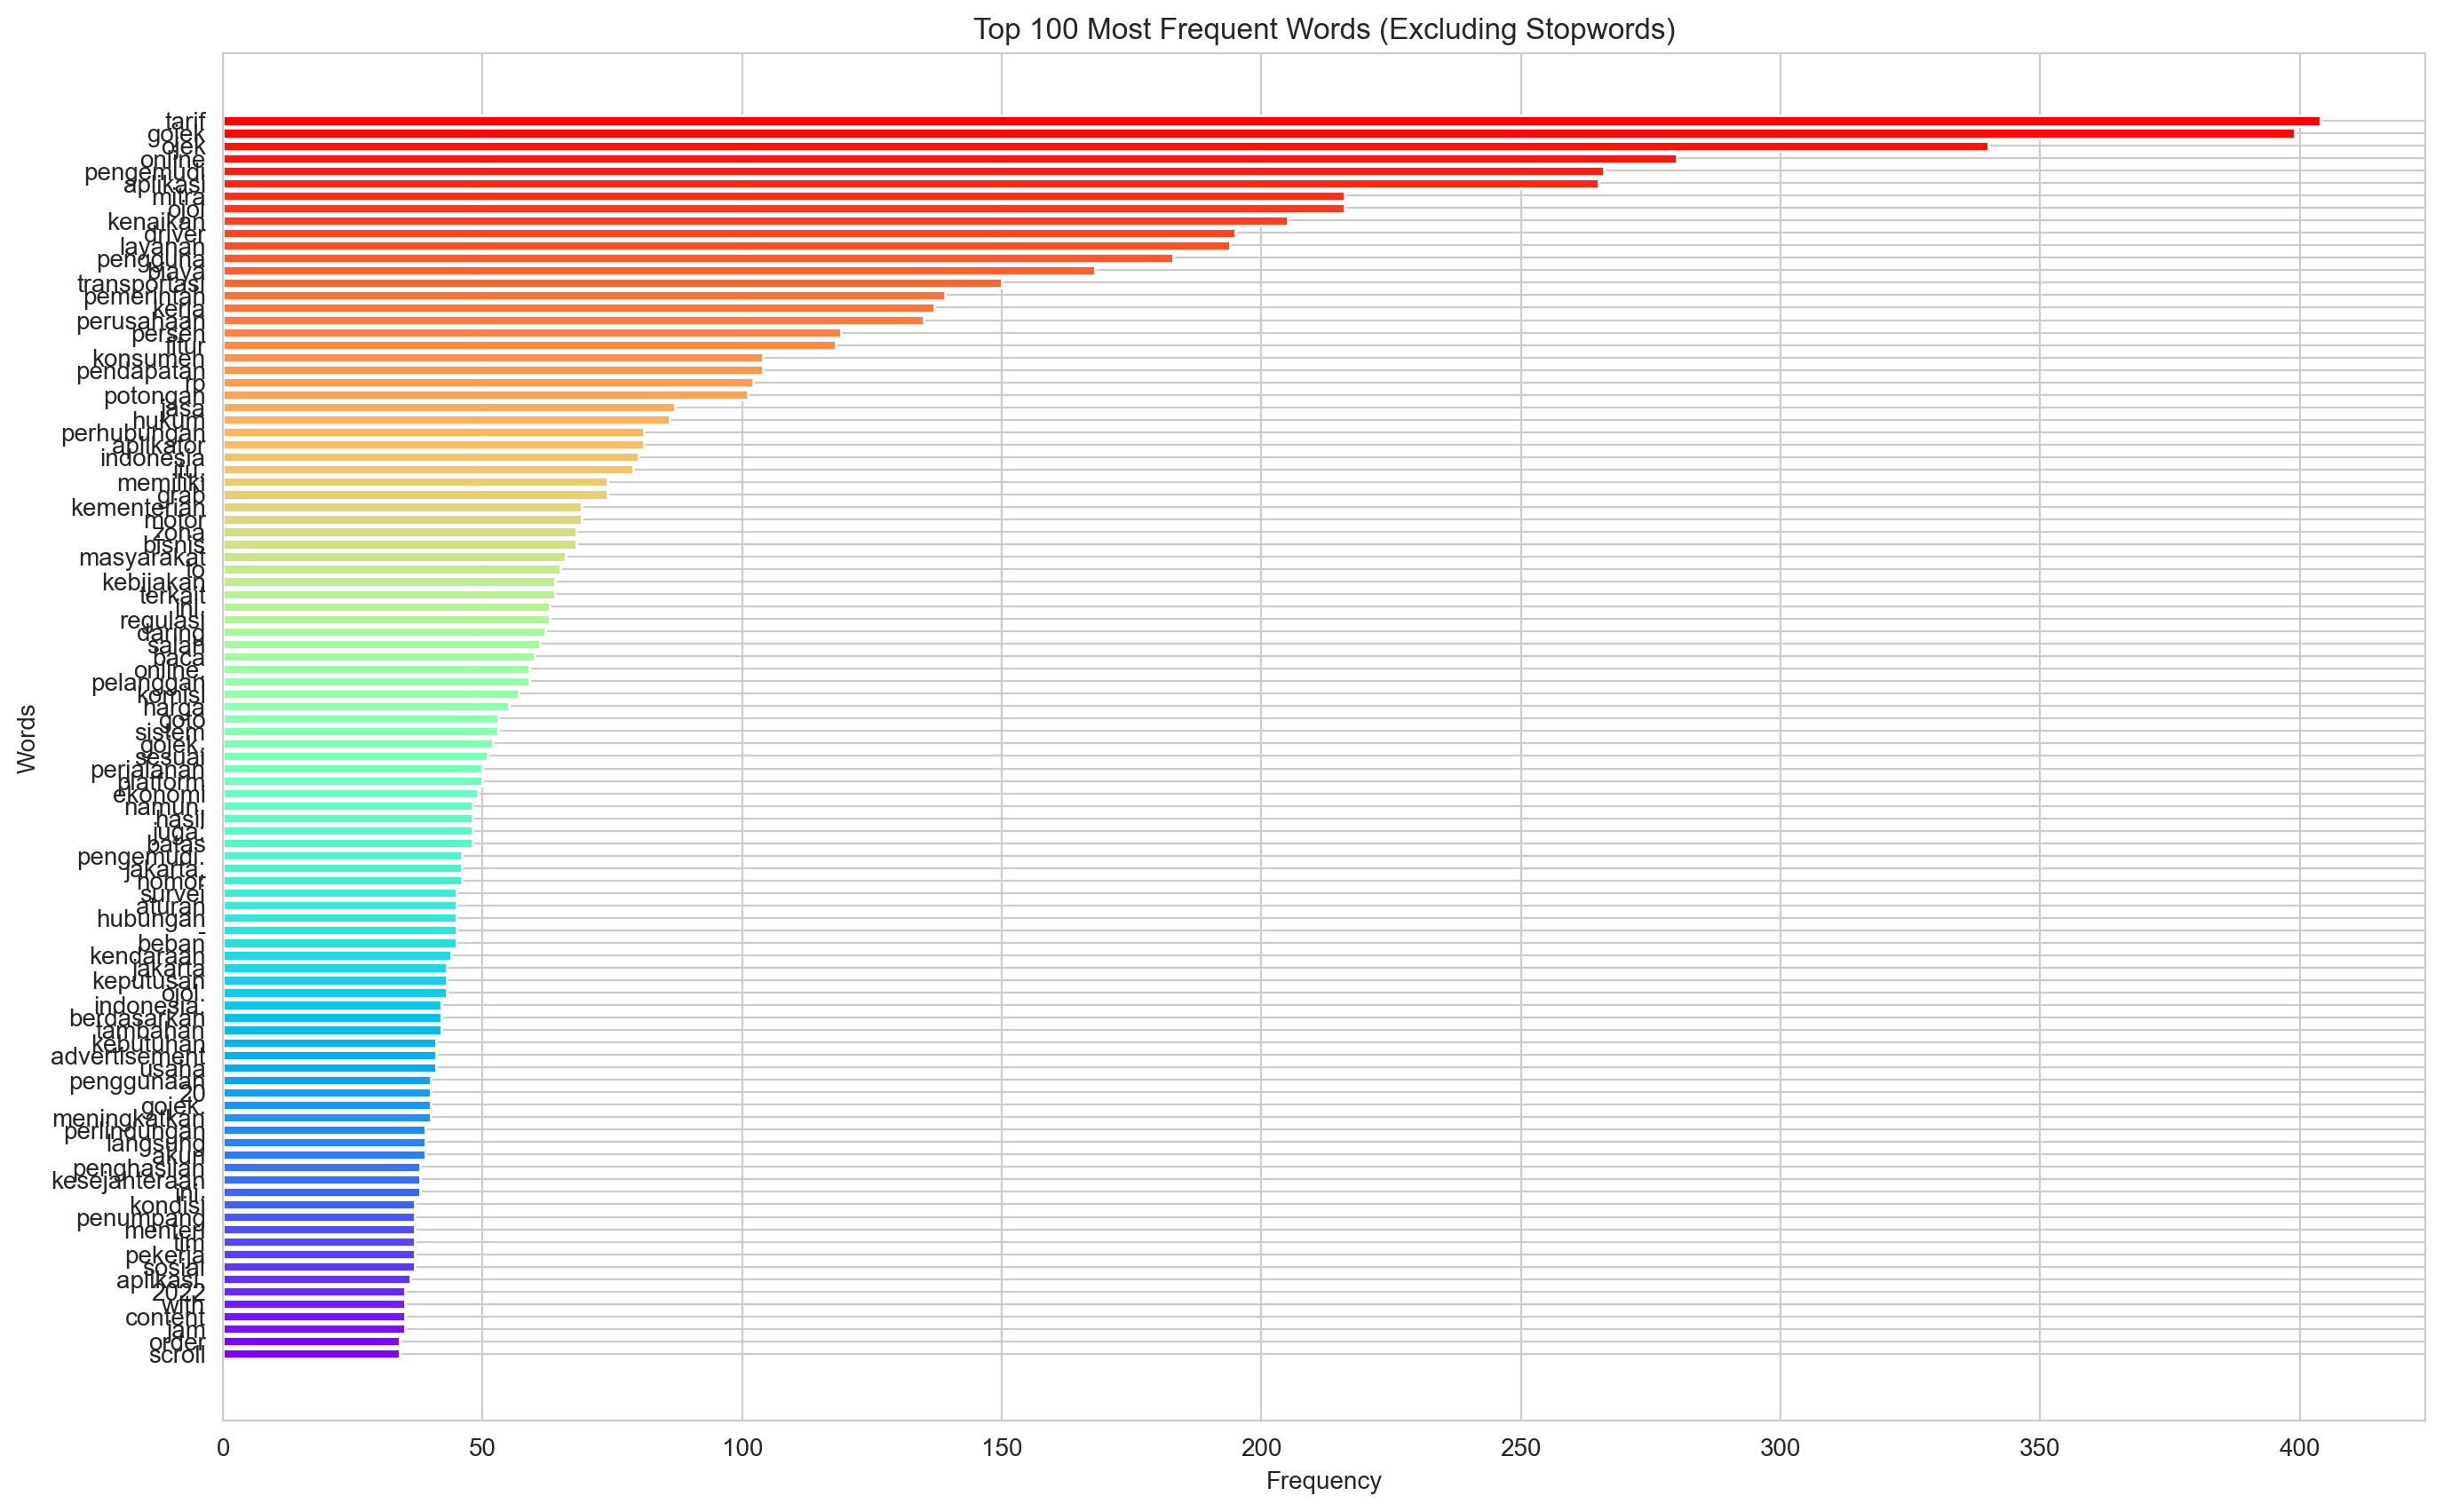

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter

# Assuming the text column is named 'content'
text_column = 'content'

# Combine all text data into one string
all_text = ' '.join(gojek_news_df[text_column].dropna().astype(str))

# Tokenize words
words = [word.lower() for word in all_text.split()]

# Cari kata yang kehapus karena stopwords
removed_words = [word for word in words if word in indonesian_stopwords]

# Hitung frekuensi kata yang kehapus
removed_counts = Counter(removed_words)
removed_df = pd.DataFrame(removed_counts.most_common(), columns=['Word', 'Frequency'])

print("🔎 Words removed by custom stopwords:")
display(removed_df)

# Filter stopwords
filtered_words = [word for word in words if word not in indonesian_stopwords]

# Count frequent words
word_counts = Counter(filtered_words)
common_words = word_counts.most_common(100)

# Convert to DataFrame for better visualization
word_freq_df = pd.DataFrame(common_words, columns=['Word', 'Frequency'])

# Display the most common words
display(word_freq_df)

# Plot the frequent words with rainbow colormap (horizontal barplot)
plt.figure(figsize=(16, 10))

# generate warna rainbow sesuai jumlah kata
colors = plt.cm.rainbow(np.linspace(0, 1, len(word_freq_df)))

# plot horizontal bar
bars = plt.barh(
    word_freq_df['Word'][::-1],
    word_freq_df['Frequency'][::-1],
    color=colors
)

plt.xlabel("Frequency")
plt.ylabel("Words")
plt.title("Top 100 Most Frequent Words (Excluding Stopwords)")
plt.show()

In [17]:

# fungsi untuk hapus stopwords
def remove_stopwords(text):
    if isinstance(text, str):
        words = text.lower().split()
        return ' '.join([w for w in words if w not in indonesian_stopwords])
    return text

# bikin kolom baru di dataframe
gojek_news_df['clean_content'] = gojek_news_df['content'].apply(remove_stopwords)

# cek hasil
print(gojek_news_df[['content', 'clean_content']].head(10))

                                             content  \
0  yogyakarta (beritajatim.com)– pemerintah melal...   
1  gojek siap kaji perubahan tarif ojek online me...   
2  rised menilai penerapan kenaikan tarif ojol di...   
3  rakyat news, jakarta – induk perusahaan gojek,...   
4  hari ini, 20 mei 2025 ojek online melakukan ak...   
5  masalah ojek online belum juga tuntas hingga s...   
6  kementerian perhubungan (kemenhub) menyesuaika...   
7  per 14 agustus besok, tarif baru ojek online (...   
8  research institute for socio-economic developm...   
9  perusahaan teknologi asal indonesia, gojek, be...   

                                       clean_content  
0  yogyakarta (beritajatim.com)– pemerintah kemen...  
1  gojek kaji perubahan tarif ojek online mengiku...  
2  rised menilai penerapan kenaikan tarif ojol di...  
3  rakyat news, jakarta – induk perusahaan gojek,...  
4  ini, 20 mei 2025 ojek online aksi massal stop ...  
5  ojek online tuntas sekarang. ojek online bahan... 

In [18]:
gojek_news_df['clean_tokens'] = gojek_news_df['tokens'].apply(
    lambda toks: [w for w in toks if w not in indonesian_stopwords]
)

In [20]:
# Liat 5 baris pertama
print(gojek_news_df[['content', 'tokens', 'clean_tokens']].head())

# Liat baris tertentu (misal index ke-100)
print(gojek_news_df[['content', 'tokens', 'clean_tokens']].iloc[75])

# Kalau mau tampil rapi (pake Pandas display)
import pandas as pd
pd.set_option('max_colwidth', 200)  # biar teksnya ga dipotong
display(gojek_news_df[['content', 'tokens', 'clean_tokens']].sample(5))

                                             content  \
0  yogyakarta (beritajatim.com)– pemerintah melal...   
1  gojek siap kaji perubahan tarif ojek online me...   
2  rised menilai penerapan kenaikan tarif ojol di...   
3  rakyat news, jakarta – induk perusahaan gojek,...   
4  hari ini, 20 mei 2025 ojek online melakukan ak...   

                                              tokens  \
0  [yogyakarta, (, beritajatim.com, ), –, pemerin...   
1  [gojek, siap, kaji, perubahan, tarif, ojek, on...   
2  [rised, menilai, penerapan, kenaikan, tarif, o...   
3  [rakyat, news, ,, jakarta, –, induk, perusahaa...   
4  [hari, ini, ,, 20, mei, 2025, ojek, online, me...   

                                        clean_tokens  
0  [yogyakarta, (, beritajatim.com, ), –, pemerin...  
1  [gojek, kaji, perubahan, tarif, ojek, online, ...  
2  [rised, menilai, penerapan, kenaikan, tarif, o...  
3  [rakyat, news, jakarta, –, induk, perusahaan, ...  
4  [20, mei, 2025, ojek, online, aksi, massal, st..

,content,tokens,clean_tokens
84,ahmad fajar mahendra (20210110400045)\r\n\r\nilmu komuniasi muhammadiyah jakarta\r\n\r\ndigital marketing merupakan pemasaran yang menggunakan platform digital pada internet. platform ini mengguna...,"[ahmad, fajar, mahendra, (, 20210110400045, ), ilmu, komuniasi, muhammadiyah, jakarta, digital, marketing, merupakan, pemasaran, yang, menggunakan, platform, digital, pada, internet, ., platform, ...","[ahmad, fajar, mahendra, (, 20210110400045, ), ilmu, komuniasi, muhammadiyah, jakarta, digital, marketing, pemasaran, platform, digital, internet, platform, alat, web, social, media, email, mening..."
43,"bisnis.com, jakarta - biaya aplikasi 30% yang dibebankan gojek kepada para mitra dinilai sebagai upaya pt goto gojek tokopedia tbk. (goto) dalam mengejar profit.\r\n\r\ndi sisi lain, mitra driver ...","[bisnis.com, ,, jakarta, -, biaya, aplikasi, 30, %, yang, dibebankan, gojek, kepada, para, mitra, dinilai, sebagai, upaya, pt, goto, gojek, tokopedia, tbk, ., (, goto, ), dalam, mengejar, profit, ...","[bisnis.com, jakarta, -, biaya, aplikasi, 30, %, dibebankan, gojek, mitra, dinilai, upaya, pt, goto, gojek, tokopedia, tbk, (, goto, ), mengejar, profit, sisi, mitra, driver, mengeluhkan, biaya, a..."
38,"peran ui/ux dalam kesuksesan aplikasi gojek\r\n\r\ndengan kemajuannya teknologi, kompetisi di sektor aplikasi mobile telah menjadi lebih sengit terutama di indonesia. di pasar yang kompetitif ini,...","[peran, ui/ux, dalam, kesuksesan, aplikasi, gojek, dengan, kemajuannya, teknologi, ,, kompetisi, di, sektor, aplikasi, mobile, telah, menjadi, lebih, sengit, terutama, di, indonesia, ., di, pasar,...","[peran, ui/ux, kesuksesan, aplikasi, gojek, kemajuannya, teknologi, kompetisi, sektor, aplikasi, mobile, sengit, indonesia, pasar, kompetitif, antarmuka, pengguna, (, ui, ), pengalaman, pengguna, ..."
9,"perusahaan teknologi asal indonesia, gojek, berencana membuat fitur alokasi prioritas untuk para penggunanya. hal ini memungkinkan para pemesan gojek dan gocar mendapatkan driver lebih cepat dari ...","[perusahaan, teknologi, asal, indonesia, ,, gojek, ,, berencana, membuat, fitur, alokasi, prioritas, untuk, para, penggunanya, ., hal, ini, memungkinkan, para, pemesan, gojek, dan, gocar, mendapat...","[perusahaan, teknologi, indonesia, gojek, berencana, fitur, alokasi, prioritas, penggunanya, pemesan, gojek, gocar, driver, cepat, pemesan, reguler, paparannya, president, unit, bisnis, on-demand-..."
47,kementerian hak asasi manusia (ham) menggelar audiensi dengan koalisi ojol nasional (kon) pada kamis (22/5/2025). pertemuan ini membahas berbagai persoalan yang dialami oleh para pengemudi ojek on...,"[kementerian, hak, asasi, manusia, (, ham, ), menggelar, audiensi, dengan, koalisi, ojol, nasional, (, kon, ), pada, kamis, (, 22/5/2025, ), ., pertemuan, ini, membahas, berbagai, persoalan, yang,...","[kementerian, hak, asasi, manusia, (, ham, ), menggelar, audiensi, koalisi, ojol, nasional, (, kon, ), kamis, (, 22/5/2025, ), pertemuan, membahas, dialami, pengemudi, ojek, online, indonesia.sekr..."


In [21]:
!pip install sastrawi


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [22]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Inisialisasi stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Apply stemming ke clean_tokens
gojek_news_df['stemmed_tokens'] = gojek_news_df['clean_tokens'].apply(
    lambda toks: [stemmer.stem(w) for w in toks]
)

# Kalau mau bikin string lagi (buat TF-IDF atau ML klasik)
gojek_news_df['final_text'] = gojek_news_df['stemmed_tokens'].apply(lambda x: ' '.join(x))

# Cek hasil
print(gojek_news_df[['content', 'clean_tokens', 'stemmed_tokens', 'final_text']].head())

                                                                                                                                                                                                   content  \
0  yogyakarta (beritajatim.com)– pemerintah melalui kementerian perhubungan tengah menyiapkan kebijakan baru yang akan menaikkan tarif ojek online (ojol) hingga 15 persen. penyesuaian tarif ini akan ...   
1  gojek siap kaji perubahan tarif ojek online mengikuti regulasi pemerintah\r\n\r\nharianjogja.com, jakarta—gojek menyatakan siap mengkaji perubahan tarif ojek online mengikuti regulasi yang berlaku...   
2  rised menilai penerapan kenaikan tarif ojol dinilai berisiko menimbulkan dampak negatif bagi semua pihak.\r\n\r\nbisnis.com, jakarta — research institute of socio-economic development (rised) meni...   
3  rakyat news, jakarta – induk perusahaan gojek, goto, memastikan bahwa gojek akan mengikuti kebijakan kenaikan tarif ojek online (ojol) roda dua yang direncanakan oleh kement

In [30]:
!pip install deep-translator
from deep_translator import GoogleTranslator
from textblob import TextBlob
import pandas as pd
import time

# misal dataframe kamu gojek_news_df
gojek_news_df['content'] = gojek_news_df['content'].astype(str)

# Translate ke Inggris
def translate_to_en(text):
    try:
        return GoogleTranslator(source='auto', target='en').translate(text)
    except Exception as e:
        return ""  # kalau error, kosongin aja sementara

gojek_news_df['content_en'] = gojek_news_df['content'].apply(translate_to_en)

# kasih jeda antar translate biar gak kena limit
time.sleep(1)

# Hitung sentimen pakai versi Inggris
gojek_news_df['sentiment_polarity'] = gojek_news_df['content_en'].apply(lambda x: TextBlob(x).sentiment.polarity)
gojek_news_df['sentiment_subjectivity'] = gojek_news_df['content_en'].apply(lambda x: TextBlob(x).sentiment.subjectivity)



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [31]:
gojek_news_df.loc[:, ["content", "sentiment_polarity", "sentiment_subjectivity"]].head(10)


,content,sentiment_polarity,sentiment_subjectivity
0,yogyakarta (beritajatim.com)– pemerintah melalui kementerian perhubungan tengah menyiapkan kebijakan baru yang akan menaikkan tarif ojek online (ojol) hingga 15 persen. penyesuaian tarif ini akan ...,0.155842,0.530833
1,"gojek siap kaji perubahan tarif ojek online mengikuti regulasi pemerintah\r\n\r\nharianjogja.com, jakarta—gojek menyatakan siap mengkaji perubahan tarif ojek online mengikuti regulasi yang berlaku...",0.120823,0.428353
2,"rised menilai penerapan kenaikan tarif ojol dinilai berisiko menimbulkan dampak negatif bagi semua pihak.\r\n\r\nbisnis.com, jakarta — research institute of socio-economic development (rised) meni...",0.000000,0.000000
3,"rakyat news, jakarta – induk perusahaan gojek, goto, memastikan bahwa gojek akan mengikuti kebijakan kenaikan tarif ojek online (ojol) roda dua yang direncanakan oleh kementerian perhubungan (keme...",0.041549,0.489680
4,"hari ini, 20 mei 2025 ojek online melakukan aksi massal stop beroperasi secara nasional. para ojek menurut adanya perbaikan masalah antara lain, tingginya potong aplikasi, tarif promo dan status h...",0.000000,0.000000
5,"masalah ojek online belum juga tuntas hingga sekarang. ojek online hanya jadi bahan diskusi, pencitraan politik serta upaya mengkapitalisasi kemiskinan – kesulitan hidup pengemudi ojek online. beb...",0.000000,0.000000
6,"kementerian perhubungan (kemenhub) menyesuaikan tarif ojek online (ojol) yang berlaku efektif 14 agustus 2022. besaran jasa batas bawah, batas atas, dan biaya jasa minimal untuk 5 kilometer (km) p...",0.071968,0.366633
7,"per 14 agustus besok, tarif baru ojek online (ojol) akan berlaku secara efektif di seluruh indonesia. para pengguna layanan jasa ini perlu bersiap-dalam menyambut kenaikan tarif ojol.\r\n\r\nketen...",0.087907,0.322755
8,"research institute for socio-economic development (rised), organisasi penelitian independen, mengungkapkan hasil survei terbarunya dari sudut pandang konsumen di indonesia berkaitan dengan tarif o...",0.123054,0.496204
9,"perusahaan teknologi asal indonesia, gojek, berencana membuat fitur alokasi prioritas untuk para penggunanya. hal ini memungkinkan para pemesan gojek dan gocar mendapatkan driver lebih cepat dari ...",0.214175,0.469408


In [48]:
# Buat kolom baru 'sentiment_rating' berdasarkan nilai sentiment_polarity
def categorize_sentiment(score):
    if score > 0.1:         # sebelumnya biasanya > 0
        return 'Positive'
    elif score < -0.1:      # sebelumnya < 0
        return 'Negative'
    else:
        return 'Neutral'


gojek_news_df['sentiment_rating'] = gojek_news_df['sentiment_polarity'].apply(label_sentiment)

# Lihat hasilnya
gojek_news_df.loc[:, ["content", "sentiment_polarity", "sentiment_subjectivity", "sentiment_rating"]].head(10)


,content,sentiment_polarity,sentiment_subjectivity,sentiment_rating
0,yogyakarta (beritajatim.com)– pemerintah melalui kementerian perhubungan tengah menyiapkan kebijakan baru yang akan menaikkan tarif ojek online (ojol) hingga 15 persen. penyesuaian tarif ini akan ...,0.155842,0.530833,Positive
1,"gojek siap kaji perubahan tarif ojek online mengikuti regulasi pemerintah\r\n\r\nharianjogja.com, jakarta—gojek menyatakan siap mengkaji perubahan tarif ojek online mengikuti regulasi yang berlaku...",0.120823,0.428353,Positive
2,"rised menilai penerapan kenaikan tarif ojol dinilai berisiko menimbulkan dampak negatif bagi semua pihak.\r\n\r\nbisnis.com, jakarta — research institute of socio-economic development (rised) meni...",0.000000,0.000000,Neutral
3,"rakyat news, jakarta – induk perusahaan gojek, goto, memastikan bahwa gojek akan mengikuti kebijakan kenaikan tarif ojek online (ojol) roda dua yang direncanakan oleh kementerian perhubungan (keme...",0.041549,0.489680,Neutral
4,"hari ini, 20 mei 2025 ojek online melakukan aksi massal stop beroperasi secara nasional. para ojek menurut adanya perbaikan masalah antara lain, tingginya potong aplikasi, tarif promo dan status h...",0.000000,0.000000,Neutral
5,"masalah ojek online belum juga tuntas hingga sekarang. ojek online hanya jadi bahan diskusi, pencitraan politik serta upaya mengkapitalisasi kemiskinan – kesulitan hidup pengemudi ojek online. beb...",0.000000,0.000000,Neutral
6,"kementerian perhubungan (kemenhub) menyesuaikan tarif ojek online (ojol) yang berlaku efektif 14 agustus 2022. besaran jasa batas bawah, batas atas, dan biaya jasa minimal untuk 5 kilometer (km) p...",0.071968,0.366633,Positive
7,"per 14 agustus besok, tarif baru ojek online (ojol) akan berlaku secara efektif di seluruh indonesia. para pengguna layanan jasa ini perlu bersiap-dalam menyambut kenaikan tarif ojol.\r\n\r\nketen...",0.087907,0.322755,Positive
8,"research institute for socio-economic development (rised), organisasi penelitian independen, mengungkapkan hasil survei terbarunya dari sudut pandang konsumen di indonesia berkaitan dengan tarif o...",0.123054,0.496204,Positive
9,"perusahaan teknologi asal indonesia, gojek, berencana membuat fitur alokasi prioritas untuk para penggunanya. hal ini memungkinkan para pemesan gojek dan gocar mendapatkan driver lebih cepat dari ...",0.214175,0.469408,Positive


In [49]:
# 1. Buat kolom sentiment_rating dari polarity
def categorize_sentiment(score):
    if score > 0.1:         # sebelumnya biasanya > 0
        return 'Positive'
    elif score < -0.1:      # sebelumnya < 0
        return 'Negative'
    else:
        return 'Neutral'




gojek_news_df['sentiment_rating'] = gojek_news_df['sentiment_polarity'].apply(label_sentiment)

# 2. Hitung jumlah tiap kategori
sentiment_counts = gojek_news_df['sentiment_rating'].value_counts()
print(sentiment_counts)

# 3. Kalau mau persentasenya juga:
sentiment_percentage = gojek_news_df['sentiment_rating'].value_counts(normalize=True) * 100
print(sentiment_percentage)


sentiment_rating
Positive    48
Neutral     46
Negative     3
Name: count, dtype: int64
sentiment_rating
Positive    49.484536
Neutral     47.422680
Negative     3.092784
Name: proportion, dtype: float64


In [36]:
gojek_news_df['sentiment_polarity'].describe()


count    97.000000
mean      0.062928
std       0.075623
min      -0.087121
25%       0.000000
50%       0.049861
75%       0.116148
max       0.303131
Name: sentiment_polarity, dtype: float64

In [41]:
!pip install wordcloud



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


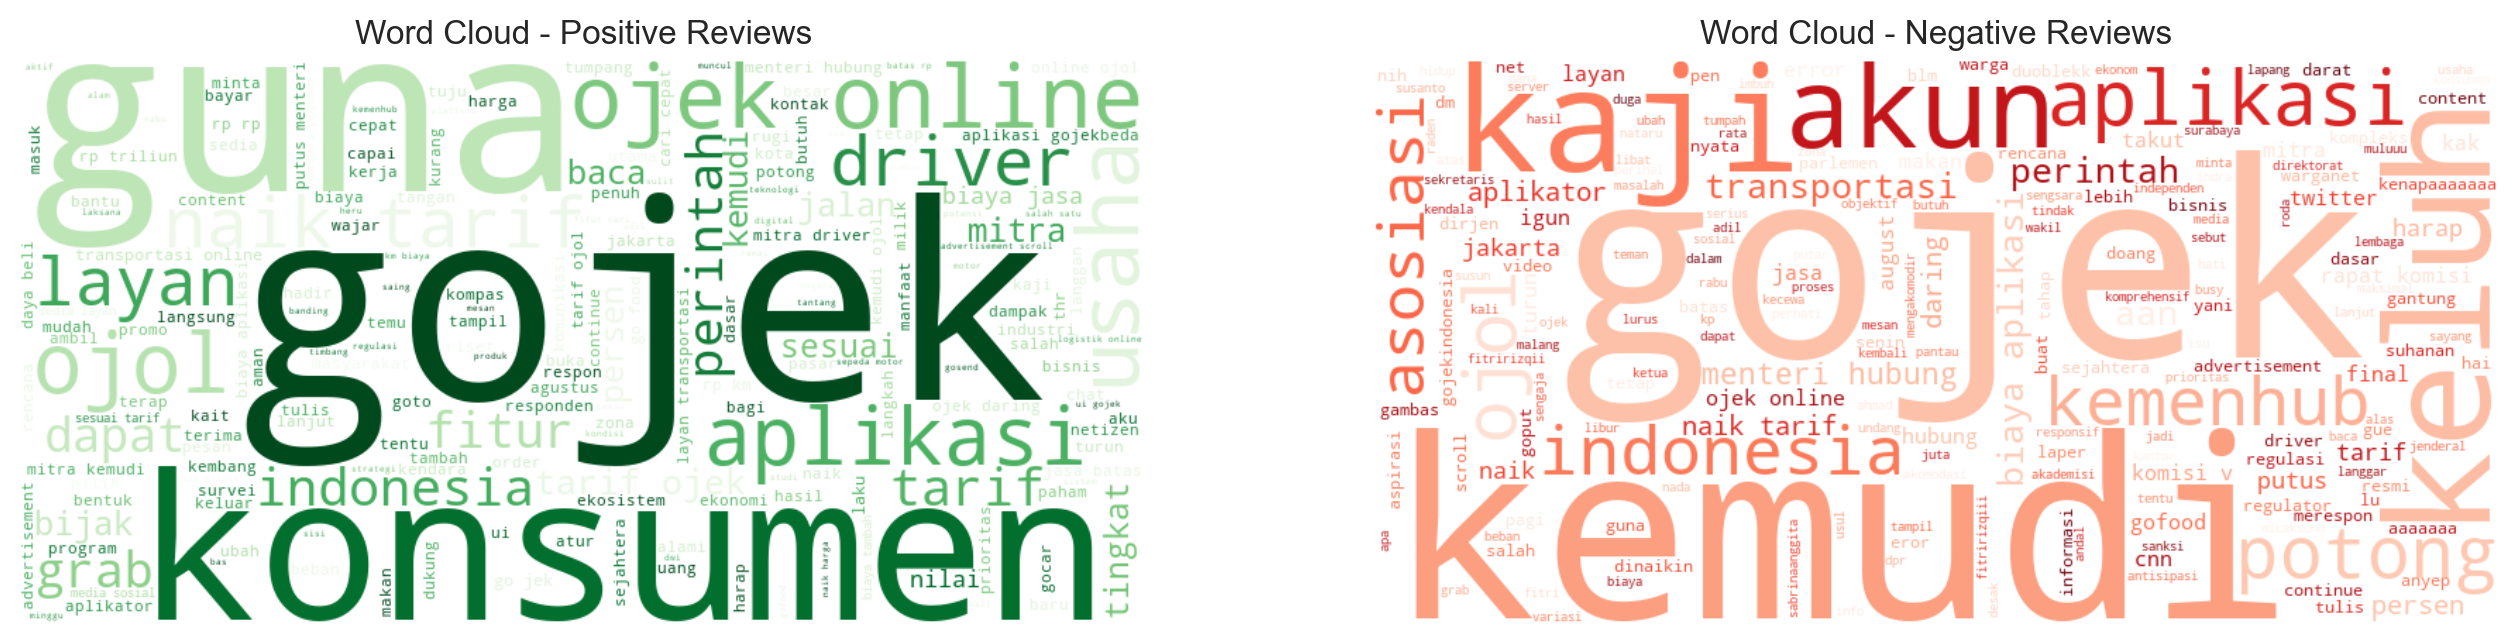

In [43]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Pisahkan review positif dan negatif
positive_text = " ".join(gojek_news_df[gojek_news_df['sentiment_rating'] == 'Positive']['final_text'])
negative_text = " ".join(gojek_news_df[gojek_news_df['sentiment_rating'] == 'Negative']['final_text'])

# Handle kalau kosong
if not positive_text:
    positive_text = "tidak ada data positif"
if not negative_text:
    negative_text = "tidak ada data negatif"

# Generate word cloud
wordcloud_pos = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(positive_text)
wordcloud_neg = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(negative_text)

# Plot dua-duanya
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Positive Reviews')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Negative Reviews')

plt.show()
